In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

In [2]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls',names=None,index_col=None)
df.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,...,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,...,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.122652,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,...,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.116682,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,...,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.118508,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,...,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.132781,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,...,0.419095,0.393447,0.160200,0.768113,0.185718,1.645807,0.296829,0.309345,1.206995,0.164650,0.160687,0.188221,0.104784,0.141983,0.167710,0.136838,0.116048,0.255528,0.140871,0.48

In [3]:
df1 = df.where(pd.notnull(df), df.mean(), axis='columns')

In [4]:
z,y = np.unique(df1['Genotype'].values, return_inverse=True)
y

array([0, 0, 0, ..., 1, 1, 1])

In [5]:
X = df1.iloc[:,1:78]
Xs = preprocessing.scale(X)

logreg = linear_model.LogisticRegression(C=1)
logreg.fit(Xs, y)

LogisticRegression(C=1)

In [6]:
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y)
print("Accuracy on training data = %f" % acc)

Accuracy on training data = 0.985185


In [7]:
data = {'feature': X.columns, 'slope': np.squeeze(logreg.coef_)}
dfslope = pd.DataFrame(data=data)
dfslope

,feature,slope
0,DYRK1A_N,0.257210
1,ITSN1_N,3.088529
2,BDNF_N,0.202844
3,NR1_N,-0.785338
4,NR2A_N,-0.323751
...,...,...
72,SYP_N,-1.255127
73,H3AcK18_N,-0.346074
74,EGR1_N,0.174129
75,H3MeK4_N,-0.210022


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

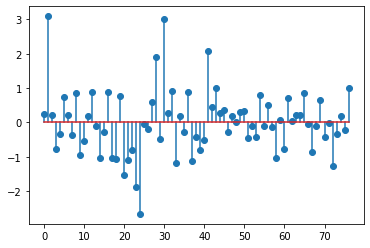

In [8]:
plt.stem(dfslope.index,dfslope['slope'])

In [9]:
Isel = (-dfslope['slope']).argsort()[:2]
print("The gene with the largest w is %s"% dfslope.feature[Isel[0]])
print("The gene with the second largest w is %s"% dfslope.feature[Isel[1]])

The gene with the largest w is ITSN1_N
The gene with the second largest w is APP_N


In [10]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import  sklearn.model_selection

nfold = 10
prec = []
rec = []
f1 = []
acc = []

kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

for train, test in kf.split(Xs): 
       
    # Get training and test data
    Xtr = Xs[train,:]
    ytr = y[train]
    Xts = Xs[test,:]
    yts = y[test]
    
    # Fit a model
    logreg.fit(Xtr, ytr)
    yhat = logreg.predict(Xts)
    
    # Measure performance
    preci,reci,f1i,_= precision_recall_fscore_support(yts,yhat,average='binary') 
    prec.append(preci)
    rec.append(reci)
    f1.append(f1i)
    acci = np.mean(yhat == yts)
    acc.append(acci)

# Take average values of the metrics
precm = np.mean(prec)
recm = np.mean(rec)
f1m = np.mean(f1)
accm= np.mean(acc)

# Compute the standard errors
prec_se = np.std(prec)/np.sqrt(nfold-1)
rec_se = np.std(rec)/np.sqrt(nfold-1)
f1_se = np.std(f1)/np.sqrt(nfold-1)
acc_se = np.std(acc)/np.sqrt(nfold-1)

print('Precision = {0:.4f}, SE={1:.4f}'.format(precm,prec_se))
print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm, rec_se))
print('f1 =        {0:.4f}, SE={1:.4f}'.format(f1m, f1_se))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm, acc_se))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Precision = 0.9792, SE=0.0036
Recall =    0.9615, SE=0.0113
f1 =        0.9700, SE=0.0067
Accuracy =  0.9722, SE=0.0063


In [11]:
z2,y2 = np.unique(df1['class'].values, return_inverse=True)
y2

array([0, 0, 0, ..., 7, 7, 7])

In [12]:
logreg = linear_model.LogisticRegression(C=1)
logreg.fit(Xs, y2)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=1)

In [13]:
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y2)
print("Accuracy on training data = %f" % acc)

Accuracy on training data = 1.000000


In [14]:
prec = []
rec = []
f1 = []
acc = []

for train, test in kf.split(Xs):            
    # Get training and test data
    Xtr = Xs[train,:]
    ytr = y2[train]
    Xts = Xs[test,:]
    yts = y2[test]
    
    # Fit a model
    logreg.fit(Xtr, ytr)
    yhat = logreg.predict(Xts)
    
    # Measure performance
    preci,reci,f1i,_= precision_recall_fscore_support(yts,yhat,average='macro') 
    prec.append(preci)
    rec.append(reci)
    f1.append(f1i)
    acci = np.mean(yhat == yts)
    acc.append(acci)
    
    # confusion matrix
    C0 = confusion_matrix(yts, yhat)
    C = C0 / C0.astype(np.float).sum(axis=1)
    print(np.array_str(C, precision=4, suppress_small=True))

# Take average values of the metrics
precm = np.mean(prec)
recm = np.mean(rec)
f1m = np.mean(f1)
accm= np.mean(acc)

# Compute the standard errors
prec_se = np.std(prec)/np.sqrt(nfold-1)
rec_se = np.std(rec)/np.sqrt(nfold-1)
f1_se = np.std(f1)/np.sqrt(nfold-1)
acc_se = np.std(acc)/np.sqrt(nfold-1)

print('Precision = {0:.4f}, SE={1:.4f}'.format(precm,prec_se))
print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm, rec_se))
print('f1 =        {0:.4f}, SE={1:.4f}'.format(f1m, f1_se))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm, acc_se))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[1.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.9333 0.     0.     0.     0.125  0.     0.    ]
 [0.     0.     1.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[0.9524 0.     0.     0.     0.1    0.     0.     0.    ]
 [0.     1.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     1.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[[1.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     1.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     1.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.875  0.     0.     0.     0.0833]
 [0.     0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]
[[1.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     1.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     1.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.0625 0.     0.     0.9231 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[[1.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     1.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     1.     0.     0.     0.     0.     0.    ]
 [0.0909 0.     0.     0.9444 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]
[[0.9375 0.1111 0.     0.     0.     0.     0.     0.    ]
 [0.     1.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     1.     0.     0.     0.     0.     0.    ]
 [0.0625 0.     0.     0.9286 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]
[[1.     0.     0.     0.     0.     0.     0.     0. 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


<StemContainer object of 3 artists>

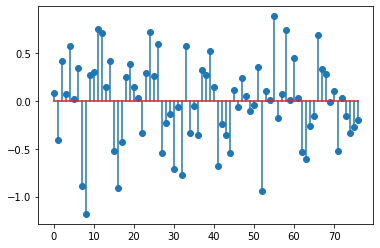

In [15]:
logreg = linear_model.LogisticRegression(C=1)
logreg.fit(Xs,y2)

w2 = np.squeeze(logreg.coef_)
plt.stem(dfslope.index,w2[0])

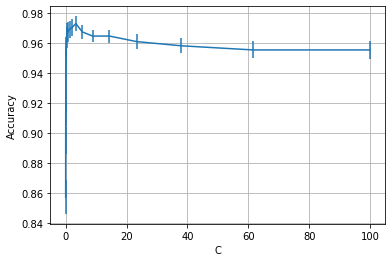

In [17]:
nc = 20
c = np.logspace(-2,2,nc)
acc = np.zeros((nc,nfold))

for ifold, ind in enumerate(kf.split(Xs)):
    
    # Get training and test data
    Itr,Its = ind
    Xtr = Xs[Itr,:]
    ytr = y[Itr]
    Xts = Xs[Its,:]
    yts = y[Its]
    
    for ia, a in enumerate(c):
    
        # Fit a model
        logreg = linear_model.LogisticRegression(C=a,penalty='l1',solver='liblinear')
        logreg.fit(Xtr, ytr)
        yhat = logreg.predict(Xts)

        # Measure accutacy
        acc[ia,ifold] = logreg.score(Xts,yts)
        
# Take average values of the metrics
accm = np.mean(acc,axis=1)
acc_se = np.std(acc,axis=1)/np.sqrt(nfold-1)

plt.errorbar(c, accm, yerr=acc_se, fmt='-')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [18]:
i = (-accm).argsort()[:1]
print("Optimal C = %f" % c[i[0]])

Optimal C = 3.359818


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


<StemContainer object of 3 artists>

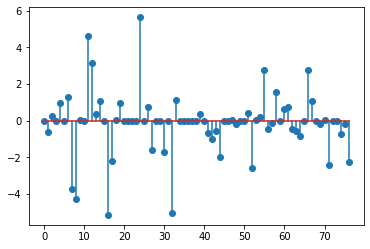

In [20]:
logreg = linear_model.LogisticRegression(C=c[i[0]],penalty='l1',solver='liblinear')
logreg.fit(Xs,y2)

w_l1 = np.squeeze(logreg.coef_)
plt.stem(dfslope.index,w_l1[0])